In [46]:
import os, glob, sys, math, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
import StructureTools
import CV
import freesasa
import joblib

Ci-dessous l'analyse des complexes en termes de :

1. Calculer SASA et rSASA pour identifier la surface (rSASA > .25) et l'interface (dSASA > 0)
2. Calculer la CV des résidus à la surface et à l'interface
3. Calculer la fréquence des 20 aa à la surface et à l'interface
4. Calculer la taille de la surface et de l'interface par monomère (en termes de nombre de résidus et de SASA en $ Å^2$).

Pour un aperçu des résultats, voir [Aperçu](#Aperçu).

# Analyse

## Create dummy folder with links for sublists

In [88]:
pwd

'/Users/marco/Dropbox/Mackup/Documents/00ENS/BIBS/BISII/repo/scripts'

In [89]:
%%bash
cd ../structures/TP1/
for d in complexes monomers; do
    cd $d;
    while read pdb; do
         ln -s ../../kihara/$d/?$pdb* .
    done < ../pdb_list
    cd ..;
done

## Deal paths

In [428]:
####################
# deal paths
#-------------------
treated_family = "kihara"
# treated_family = "TP1"

cplxpath = "../structures/%s/complexes/"%(treated_family)
monopath = "../structures/%s/monomers/"%(treated_family)
print(cplxpath)
print("%s complexes to treat"%(len(os.listdir(cplxpath))))
print(os.listdir(cplxpath))
print(monopath)
print("%s monomers to treat"%(len(os.listdir(monopath))))
print(os.listdir(monopath))

../structures/kihara/complexes/
65 complexes to treat
['t1F6M_AC_cplx.pdb', 't1GCQ_AC_cplx.pdb', 't1I4D_AD_cplx.pdb', 'p1AY7_AB_cplx.pdb', 'p1UUG_AB_cplx.pdb', 'p1EMV_AB_cplx.pdb', 'p2OUL_AB_cplx.pdb', 'p2OZA_AB_cplx.pdb', 't1LFD_AB_cplx.pdb', 'p2SNI_EI_cplx.pdb', 'p1EER_AB_cplx.pdb', 'p1BVN_PT_cplx.pdb', 'p1WDW_AB_cplx.pdb', 'p1GXD_AC_cplx.pdb', 'p2O3B_AB_cplx.pdb', 't1Z0K_AB_cplx.pdb', 't1A15_AB_cplx.pdb', 't1EWY_AC_cplx.pdb', 'p1OPH_AB_cplx.pdb', 'p1M10_AB_cplx.pdb', 'p1AVX_AB_cplx.pdb', 'p3SGB_EI_cplx.pdb', 't1FFW_AB_cplx.pdb', 'p1JTG_AB_cplx.pdb', 't1HE8_AB_cplx.pdb', 'p2BTF_AP_cplx.pdb', 'p1JIW_IP_cplx.pdb', 't2TGP_IZ_cplx.pdb', 'p1T6B_XY_cplx.pdb', 't1US7_BA_cplx.pdb', 't1S1Q_AB_cplx.pdb', 'p1DFJ_EI_cplx.pdb', 'p1BRS_AD_cplx.pdb', 'p1PXV_AC_cplx.pdb', 'p2J0T_AD_cplx.pdb', 'p1PPE_EI_cplx.pdb', 't1A78_AB_cplx.pdb', 't1QA9_AB_cplx.pdb', 't1J2J_AB_cplx.pdb', 't1WQ1_RG_cplx.pdb', 'p1ATN_DA_cplx.pdb', 'p1GPW_AB_cplx.pdb', 'p2GOX_AB_cplx.pdb', 't2FJU_AB_cplx.pdb', 't2PCB_AB_cplx.pdb', 

## Some usefule definitions

In [429]:
def multipleKStest(l1, l2):
    pvalues = []
    for i in range(1000) :
        
        pvalues.append(kstest(random.sample(l1, k = 200), random.sample(l2, k = 200)).pvalue)
    
    return sum(pvalues)/len(pvalues)

In [430]:
def writeDistribValues(listowrite, flagtowrite):
    """write the values in the list in a text file (1 col) -> output name is defined according to flagtowrite """
    fout = open("%s.txt"%(flagtowrite),"w")
    for val in listowrite:
        fout.write("%s\n"%(val))
        
    fout.close()

## Calculate SASA and define surface/interface

In [431]:
############################################################################@
#
#           Identification of interface and surface residues
#
############################################################################@

def assignChainsToLigAndRec(dASAcp, dASAlig, dASArec):
    """assign each chain of the complex to the lig or rec dict"""
        
    for chncp in dASAcp :
        if chncp in dASAlig: # means the first chain is the ligand
            first = "lig"
            second = "rec"
            return first, second
        else:
            first = "rec"
            second = "lig"
            return first, second
                

In [432]:
def getSurfRes(dASAcp, dASAlig, dASArec):
    """extract surface residues through the comparison of their ASA in the monomer VS complex"""
        
    #init var
    ligsurf = []
    liginter = []
    recsurf = []
    recinter = []
    flag = 0
        
    # assign each chain of the complex to the lig or rec dict
    firstchain, secondchain = assignChainsToLigAndRec(dASAcp, dASAlig, dASArec)
    print("firstchain %s secondchain %s "%(firstchain, secondchain))     
    monostatus = firstchain
    
    for chncp in dASAcp :
        #print("curchain %s"%(chncp))
                            
        for rescp in dASAcp[chncp] :
                
            if monostatus == "lig" : #means the current chain is the lig
                        
                dASA = dASAlig[chncp][str(rescp)].relativeTotal - dASAcp[chncp][str(rescp)].relativeTotal
                    
                if dASA > 0 : # means the ASA in the lig is greater than in the cplx form, so the res is buried in the interface
                        
                    liginter.append(rescp)
                    ligsurf.append(rescp)
                else:
                    if dASAlig[chncp][str(rescp)].relativeTotal > 0.25 : # means the res is located on the lig surface
                        ligsurf.append(rescp)
            else :
                #print("dASARec.keys() %s"%(dASArec.keys()))
                #print("rescp %s "%(rescp))
                #print(dASArec["A"]["5"])
                dASA = dASArec[chncp][str(rescp)].relativeTotal - dASAcp[chncp][str(rescp)].relativeTotal
                    
                if dASA > 0 : # means the ASA in the lig is greater than in the cplx form, so the res is buried in the interface
                        
                    recinter.append(rescp)
                    recsurf.append(rescp)
                else:
                    if dASArec[chncp][str(rescp)].relativeTotal > 0.25 : # means the res is located on the lig surface
                        recsurf.append(rescp)
                    
                    
        # get status of second chain (contained in secondchain)          
        monostatus = secondchain
            
    return recsurf, ligsurf, recinter, liginter


In [433]:
#compute SASA of each mono and cplx

dico_inter_surf = {}
cv_intertmp = []
cv_surftmp = []

for cp in os.listdir(cplxpath) :
    

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # init dico for this complex
    dico_inter_surf[rootname] = {}
    dico_inter_surf[rootname]["lig"] = {}
    dico_inter_surf[rootname]["rec"] = {}
    
    # compute SASA for the cplx
    strcplx = freesasa.Structure("%s/%s"%(cplxpath, cp))
    outASAcplx = freesasa.calc(strcplx)
    dASAcp = outASAcplx.residueAreas()
    
    # compute SASA for the lig
    strlig = freesasa.Structure("%s/%s"%(monopath, monol))
    outASAlig = freesasa.calc(strlig)
    dASAlig = outASAlig.residueAreas()
    
    # compute SASA for the lig
    strrec = freesasa.Structure("%s/%s"%(monopath, monor))
    outASArec = freesasa.calc(strrec)
    dASArec = outASArec.residueAreas()

    recsurf, ligsurf, recinter, liginter = getSurfRes(dASAcp, dASAlig, dASArec)
    
    def getSASA(resi, dASA):
        tot = 0
        chncp = list(dASA.keys())[0]
        for res in resi:
            tot += dASA[chncp][str(res)].total
        return tot

    dico_inter_surf[rootname]["lig"]["surf"] = ligsurf 
    dico_inter_surf[rootname]["lig"]["inter"] = liginter
    dico_inter_surf[rootname]["rec"]["surf"] = recsurf
    dico_inter_surf[rootname]["rec"]["inter"] = recinter 
    dico_inter_surf[rootname]["lig"]["surfSASA"] = getSASA(ligsurf, dASAlig)
    dico_inter_surf[rootname]["rec"]["surfSASA"] = getSASA(recsurf, dASArec)
    dico_inter_surf[rootname]["lig"]["interSASA"] = getSASA(liginter, dASAlig)
    dico_inter_surf[rootname]["rec"]["interSASA"] = getSASA(recinter, dASArec)

    #print("list of interface residues in REC")
    #print(recinter)
    #print("list of interface residues in LIG")
    #print(liginter)


dealing with t1F6M_AC 
 t1F6M_AC_r_inter.pdb \t1F6M_AC_l_inter.pdb
firstchain lig secondchain rec 
dealing with t1GCQ_AC 
 t1GCQ_AC_r_inter.pdb \t1GCQ_AC_l_inter.pdb
firstchain lig secondchain rec 
dealing with t1I4D_AD 
 t1I4D_AD_r_inter.pdb \t1I4D_AD_l_inter.pdb
firstchain rec secondchain lig 
dealing with p1AY7_AB 
 p1AY7_AB_r_inter.pdb \p1AY7_AB_l_inter.pdb
firstchain rec secondchain lig 
dealing with p1UUG_AB 
 p1UUG_AB_r_inter.pdb \p1UUG_AB_l_inter.pdb
firstchain rec secondchain lig 
dealing with p1EMV_AB 
 p1EMV_AB_r_inter.pdb \p1EMV_AB_l_inter.pdb
firstchain lig secondchain rec 
dealing with p2OUL_AB 
 p2OUL_AB_r_inter.pdb \p2OUL_AB_l_inter.pdb
firstchain rec secondchain lig 
dealing with p2OZA_AB 
 p2OZA_AB_r_inter.pdb \p2OZA_AB_l_inter.pdb
firstchain lig secondchain rec 
dealing with t1LFD_AB 
 t1LFD_AB_r_inter.pdb \t1LFD_AB_l_inter.pdb
firstchain lig secondchain rec 
dealing with p2SNI_EI 
 p2SNI_EI_r_inter.pdb \p2SNI_EI_l_inter.pdb
firstchain rec secondchain lig 
dealing wi

In [434]:
# Store the dict to file
joblib.dump(dico_inter_surf, "../analysis/dico_inter_surf_{}.job".format(treated_family))

['../analysis/dico_inter_surf_kihara.job']

In [51]:
dico_inter_surf = joblib.load("../analysis/dico_inter_surf_{}.job".format(treated_family))

## CV

In [435]:
############################################################################@
#
#                        Calculation of CV
#
############################################################################@

def getCV_fromResList(d_pdb, chainID, reslist):
    
    cv = []
    
    for resi in d_pdb[chainID]["reslist"] :
        if reslist is None or resi in reslist :
            firstatom = d_pdb[chainID][resi]["atomlist"][0] # get the first atom and then the corresponding cv since the CV is identical for all atoms
            cv.append(d_pdb[chainID][resi][firstatom]["bfactor"])
            
    return cv

In [512]:
# calculation of the CV of each residue of each monomer with the CV module
#--------------------------------------------------------------------------

#init var
rc = 8 #radius for CV calculation
cv_intertmp = {}
cv_surftmp = {}

# compute res CV for each monomer
for cp in os.listdir(cplxpath) :
    

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig, atomlistlig = StructureTools.PDB_parser("%s/%s"%(monopath, monol), returnatomlist=True)
    #print(d_pdblig["chains"])
    chainlig = d_pdblig["chains"][0]
    d_pdbrec, atomlistrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor), returnatomlist=True)
    chainrec = d_pdbrec["chains"][0]

    # calcule la variance variance circulaire de chq atome --> returns the average per residue
    CV.CV_AllRes(atomlistlig, d_pdblig, chainlig, rc)
    CV.CV_AllRes(atomlistrec, d_pdbrec, chainrec, rc)

    # get CV for all res of the interface
    cv_intertmp[rootname] = [
        getCV_fromResList(d_pdblig, chainlig,
                            dico_inter_surf[rootname]["lig"]["inter"]),
        getCV_fromResList(d_pdbrec, chainrec,
                            dico_inter_surf[rootname]["rec"]["inter"])]
    # get CV for all res of the surface
    cv_surftmp[rootname] = [
        getCV_fromResList(d_pdblig, chainlig, 
                            dico_inter_surf[rootname]["lig"]["surf"]),
        getCV_fromResList(d_pdbrec, chainrec, 
                            dico_inter_surf[rootname]["rec"]["surf"])]

# store CV
cv_inter = [lr for cvlist in cv_intertmp.values() for cv in cvlist for lr in cv]
cv_surf = [lr for cvlist in cv_surftmp.values() for cv in cvlist for lr in cv]


dealing with t1F6M_AC 
 t1F6M_AC_r_inter.pdb \t1F6M_AC_l_inter.pdb
dealing with t1GCQ_AC 
 t1GCQ_AC_r_inter.pdb \t1GCQ_AC_l_inter.pdb
dealing with t1I4D_AD 
 t1I4D_AD_r_inter.pdb \t1I4D_AD_l_inter.pdb
dealing with p1AY7_AB 
 p1AY7_AB_r_inter.pdb \p1AY7_AB_l_inter.pdb
dealing with p1UUG_AB 
 p1UUG_AB_r_inter.pdb \p1UUG_AB_l_inter.pdb
dealing with p1EMV_AB 
 p1EMV_AB_r_inter.pdb \p1EMV_AB_l_inter.pdb
dealing with p2OUL_AB 
 p2OUL_AB_r_inter.pdb \p2OUL_AB_l_inter.pdb
dealing with p2OZA_AB 
 p2OZA_AB_r_inter.pdb \p2OZA_AB_l_inter.pdb
dealing with t1LFD_AB 
 t1LFD_AB_r_inter.pdb \t1LFD_AB_l_inter.pdb
dealing with p2SNI_EI 
 p2SNI_EI_r_inter.pdb \p2SNI_EI_l_inter.pdb
dealing with p1EER_AB 
 p1EER_AB_r_inter.pdb \p1EER_AB_l_inter.pdb
dealing with p1BVN_PT 
 p1BVN_PT_r_inter.pdb \p1BVN_PT_l_inter.pdb
dealing with p1WDW_AB 
 p1WDW_AB_r_inter.pdb \p1WDW_AB_l_inter.pdb
dealing with p1GXD_AC 
 p1GXD_AC_r_inter.pdb \p1GXD_AC_l_inter.pdb
dealing with p2O3B_AB 
 p2O3B_AB_r_inter.pdb \p2O3B_AB_l_inter

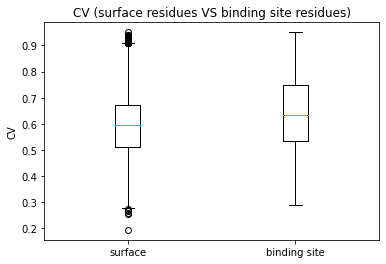

In [513]:
# plot CV distributions for surface and interface residues
#---------------------------------------------------------
fig1, ax1 = plt.subplots()
ax1.set_title('CV (surface residues VS binding site residues)')
ax1.boxplot([cv_surf, cv_inter])
plt.xticks([1, 2], ['surface', 'binding site']);
plt.ylabel("CV")
plt.savefig("../analysis/plots/CV_surf_vs_BS_%s.png"%(treated_family))

In [514]:
# write values in files
writeDistribValues(cv_surf, "../analysis/data/CV_surf_%s"%(treated_family))
writeDistribValues(cv_inter, "../analysis/data/CV_inter_%s"%(treated_family))


In [515]:
# KS test (2-sided) for CV between surf and interface residues
pval = multipleKStest(cv_surf, cv_inter)
print(pval)
kstest(cv_surf, cv_inter)


0.00813401445745334


KstestResult(statistic=0.17546506699190656, pvalue=1.5658821594496683e-79)

In [516]:
dico_CV = dict(
            surf=cv_surftmp,
            inter=cv_intertmp)
joblib.dump(dico_CV,
             "../analysis/dico_CV_{}.job".format(treated_family))

['../analysis/dico_CV_kihara.job']

## Propensities

In [440]:
############################################################################@
#
#           Calculation of amino acid propensities for being in interfaces
#
#           N.B.: modified to obtain counts, not fractions !!!
#
############################################################################@


def compFreqAA_fromResList(d_pdb, chainID, reslist, d_aa, verbose=False):
    
    d_aa_tmp = {aa:0 for aa in AA}
 
    # count the nb of each aa 
    for resi in d_pdb[chainID]["reslist"] :
        if resi in reslist :
            aa = d_pdb[chainID][resi]["resname"]
            d_aa_tmp[aa] +=1
    
    # normalize with the size of studied area (e.g. interface or surface) and store the result in d_aa
    for aa in d_aa_tmp :
        if verbose:
            print("{}: {}/{}".format(aa, d_aa_tmp[aa], len(reslist)))
        #d_aa_tmp[aa] = d_aa_tmp[aa]/len(reslist)
        d_aa[aa].append(d_aa_tmp[aa])
        
    

In [441]:
# calculation of the aa freq in interfaces and surfaces, then calculation of the resulting propensities
#-------------------------------------------------------------------------------------------------------

#init var
AA = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR".split()
d_aa_surf_cmt = {aa:[] for aa in AA}
d_aa_inter_cmt = {aa:[] for aa in AA}

# compute res CV for each monomer
for cp in os.listdir(cplxpath) :

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    #print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig = StructureTools.PDB_parser("%s/%s"%(monopath, monol))
    chainlig = d_pdblig["chains"][0]
    d_pdbrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor))
    chainrec = d_pdbrec["chains"][0]

    # compute the freq of each aa for inter and surf
    compFreqAA_fromResList(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["inter"], d_aa_inter_cmt)
    compFreqAA_fromResList(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["inter"], d_aa_inter_cmt)
    compFreqAA_fromResList(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["surf"], d_aa_surf_cmt)
    compFreqAA_fromResList(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["surf"], d_aa_surf_cmt)
    
# compute propension for being located at interfaces (i.e. stickiness)
d_prop_aa = {}
## GET ALL SIZES, then sum
a = np.array([[len(cplx[lr][si]) for si in ("surf", "inter") for lr in ("lig","rec")] 
              for pdb, cplx in dico_inter_surf.items()])
sizes = np.concatenate((a[:, [0,2]], a[:, [1,3]]))
for aa in d_aa_inter_cmt :
    
    #d_prop_aa[aa] = math.log2(np.mean(d_aa_inter_cmt[aa])/np.mean(d_aa_surf_cmt[aa]))
    # Note that comparable results can be achieved by storing the non-normalised 
    # frequencies and the interface/surface sizes, take the ratio of the sums,
    # then take the log2 of the ratio of those :
    d_prop_aa[aa] = math.log2((np.sum(d_aa_inter_cmt[aa])/sizes[:, 1].sum()) / 
                              (np.sum(d_aa_surf_cmt[aa])/sizes[:, 0].sum()))



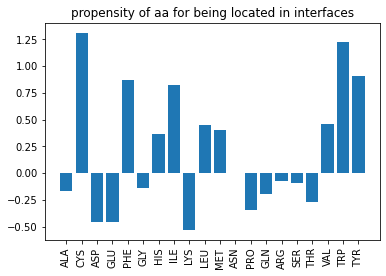

In [442]:
#  plot aa propensities
#----------------------

aaprop = []
aanames = []

xx = range(20)

for i in  d_prop_aa :
    aaprop.append(d_prop_aa[i])
    aanames.append(i)
    
plt.bar(xx, aaprop)
plt.title("propensity of aa for being located in interfaces")
plt.xticks(range(20), aanames, rotation = 90);
plt.savefig("../analysis/plots/aa_propensities_%s.png"%(treated_family))

In [443]:
# write values in files
writeDistribValues(aaprop, "aaprop_%s"%(treated_family))


In [716]:
############################################################################@###########@
#
#           Calculation of hydrophobic vs hydrophilic residue frequencies in interfaces
#
#           N.B.: modified to obtain counts, not fractions !!!
#
############################################################################@###########@
TYPES = ("CHG", "POL", "HB")
AA_TY = dict(
    HB = ["VAL","ILE","LEU","MET","PHE","TRP",  "ALA","CYS","PRO"],  # -TYR
    CHG = ["ARG","LYS","GLU","ASP","HIS"],
    POL = ["SER","THR","ASN","GLN",  "TYR","GLY"]
)

def compNB_HB_POL(d_pdb, chainID, reslist, d_HBPOL, name):

    d_tmp = {x: 0 for x in TYPES}
    d_tmp2 = {x: 0 for x in TYPES}

    # count the nb of each aa 
    for resi in d_pdb[chainID]["reslist"] :
        if resi in reslist :
            aa = d_pdb[chainID][resi]["resname"]
            if aa in AA_TY['HB'] :
                d_tmp["HB"] +=1
            elif aa in AA_TY['POL'] :
                d_tmp["POL"] +=1
            elif aa in AA_TY['CHG'] :
                d_tmp["CHG"] +=1
            for ty in TYPES:
                if aa in AA_TY[ty]:
                    d_tmp2[ty] +=1
            
    assert d_tmp == d_tmp2

    # normalize with the size of studied area (e.g. interface or surface) and store the result in d_aa
    for aatype in d_tmp :
        # d_tmp[aatype] = d_tmp[aatype] /len(reslist)
        d_HBPOL[aatype][name].append(d_tmp[aatype])
        

from collections import defaultdict
# calculation of the aa freq in interfaces and surfaces, then calculation of the resulting propensities
#-------------------------------------------------------------------------------------------------------

#init var
d_HBPOLsurf = {x: defaultdict(list) for x in TYPES}
d_HBPOLinter = {x: defaultdict(list) for x in TYPES}


# compute res CV for each monomer
for cp in os.listdir(cplxpath) :

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    #print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig = StructureTools.PDB_parser("%s/%s"%(monopath, monol))
    chainlig = d_pdblig["chains"][0]
    d_pdbrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor))
    chainrec = d_pdbrec["chains"][0]

    # compute the freq of each aa for inter and surf
    compNB_HB_POL(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["inter"], 
                  d_HBPOLinter, rootname)
    compNB_HB_POL(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["inter"], 
                  d_HBPOLinter, rootname)
    compNB_HB_POL(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["surf"], 
                  d_HBPOLsurf, rootname)
    compNB_HB_POL(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["surf"], 
                  d_HBPOLsurf, rootname)

## Make list versions
def d_linearise(d_HBPOL):
    ret = {}
    for i in d_HBPOL.keys():
        ret[i] = [nres for lr in d_HBPOL[i].values() for nres in lr]
    return ret

l_HBPOLsurf = d_linearise(d_HBPOLsurf)
l_HBPOLinter = d_linearise(d_HBPOLinter)

## Make ndarray versions (easyer to sum by column)
a_HBPOLinter = np.array([l_HBPOLinter[ty] for ty in TYPES]).T
a_HBPOLsurf = np.array([l_HBPOLsurf[ty] for ty in TYPES]).T

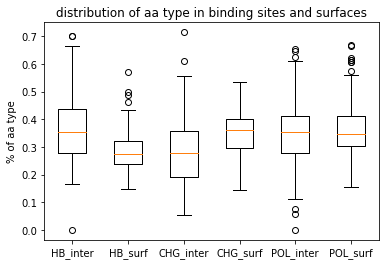

In [733]:
# plot HB/POL/CHG distributions for surface and interface residues
#---------------------------------------------------------
fig1, ax1 = plt.subplots()
iCHG, iPOL, iHB = 0, 1, 2
ax1.boxplot([data for ty in (iHB, iCHG, iPOL)
    for data in [a_HBPOLinter[:, ty]/a_HBPOLinter.sum(axis=1),  # normalise by size
                 a_HBPOLsurf[:, ty]/a_HBPOLsurf.sum(axis=1)]])  # normalise by size
ax1.set_title('distribution of aa type in binding sites and surfaces')
plt.xticks(range(1,7), ['HB_inter', 'HB_surf', 'CHG_inter', 'CHG_surf', 'POL_inter', 'POL_surf']);
plt.ylabel("% of aa type")
plt.savefig("../analysis/plots/HB_POL_CHG_surf_vs_BS_%s.png"%(treated_family))

In [569]:
# write values in files
writeDistribValues(l_HBPOLsurf["HB"], "../analysis/data/HB_surf_%s"%(treated_family))
writeDistribValues(l_HBPOLinter["HB"], "../analysis/data/HB_inter_%s"%(treated_family))
writeDistribValues(l_HBPOLsurf["CHG"], "../analysis/data/CHG_surf_%s"%(treated_family))
writeDistribValues(l_HBPOLinter["CHG"], "../analysis/data/CHG_inter_%s"%(treated_family))
writeDistribValues(l_HBPOLsurf["POL"], "../analysis/data/POL_surf_%s"%(treated_family))
writeDistribValues(l_HBPOLinter["POL"], "../analysis/data/POL_inter_%s"%(treated_family))

## Sizes

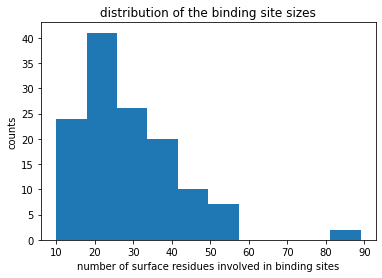

In [752]:
############################################################################@
#
#           Plot of the distribution of interface sizes
#
############################################################################@


# get interface sizes
sizes =[]
for cplx in dico_inter_surf :
    sizes.append(len(dico_inter_surf[cplx]["lig"]["inter"]))
    sizes.append(len(dico_inter_surf[cplx]["rec"]["inter"]))

    #s = [len(dico_inter_surf[x]["lig"]["surf"]) for x in dico_inter_surf]
# plot the size distribution
plt.hist(sizes, 10);
plt.title("distribution of the binding site sizes")
plt.xlabel("number of surface residues involved in binding sites")
plt.ylabel("counts")
plt.savefig("../analysis/plots/bindingSiteSizes_distrib_%s.png"%(treated_family))

In [448]:
# write values in file
writeDistribValues(sizes, "../analysis/data/sizes_%s"%(treated_family))


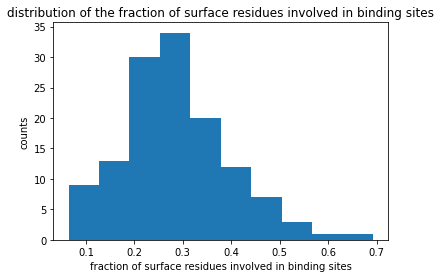

In [449]:
############################################################################@##########@
#
#           Plot of the distribution of interface sizes normalized by the surface size
#
############################################################################@##########@


# get interface sizes
sizes_norm =[]
for cplx in dico_inter_surf :
    sizes_norm.append(len(dico_inter_surf[cplx]["lig"]["inter"])/len(dico_inter_surf[cplx]["lig"]["surf"]))
    sizes_norm.append(len(dico_inter_surf[cplx]["rec"]["inter"])/len(dico_inter_surf[cplx]["rec"]["surf"]))

    #s = [len(dico_inter_surf[x]["lig"]["surf"]) for x in dico_inter_surf]
# plot the size distribution
plt.hist(sizes_norm);
plt.title("distribution of the fraction of surface residues involved in binding sites")
plt.xlabel("fraction of surface residues involved in binding sites")
plt.ylabel("counts")
plt.savefig("../analysis/plots/bindingSiteFraction_distrib_%s.png"%(treated_family))

In [450]:
# write values in file
writeDistribValues(sizes_norm, "../analysis/data/norm_sizes_%s"%(treated_family))


## Total sizes

In [451]:
total_sizes = {}
# compute total size
for cp in os.listdir(cplxpath) :
    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    #print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig = StructureTools.PDB_parser("%s/%s"%(monopath, monol))
    chainlig = d_pdblig["chains"][0]
    d_pdbrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor))
    chainrec = d_pdbrec["chains"][0]
    total_sizes[rootname] = dict(
        lig = len(d_pdblig[chainlig]['reslist']),
        rec = len(d_pdbrec[chainrec]['reslist'])
    )


# Write CSVs
In the following, a trick is implemented to write per-group CSVs in the order specified in a list.

In [452]:
# outdir = "../../ppt/TP_1/CSV_28complexes"  # structures/TP1
outdir = "../../ppt/TP_1/CSV_kihara"  # structures/kihara
complex_order = list(map(str.strip, open(os.path.join(outdir, "pdb_list")).readlines()))

In [517]:
dico_CV = joblib.load("../analysis/dico_CV_{}.job".format(treated_family))
dico_inter_surf = joblib.load("../analysis/dico_inter_surf_{}.job".format(treated_family))

In [576]:
# Combine HBPOL
# XXX TODO: make this structure in Section 1.
dico_HBPOLn = {}
for cplx in dico_inter_surf.keys():
    key = cplx[1:]
    dico_HBPOLn[key] = dict(surf={}, inter={})
    for ty in ("HB", "POL", "CHG"):
        dico_HBPOLn[key]['surf'][ty] = sum(d_HBPOLsurf[ty][cplx])   # summing two monomers
        dico_HBPOLn[key]['inter'][ty] = sum(d_HBPOLinter[ty][cplx]) # summing two monomers

In [592]:
# Modify dico_inter_surf's keynames
dico_inter_surfn = {k[1:]:v for k,v in dico_inter_surf.items()}
dico_CVn = {k:{l[1:]:w for l,w in v.items()} for k,v in dico_CV.items()}

In [746]:
assert set(complex_order) == set(dico_inter_surfn.keys())

## Tache 5.3: Tailles en #res
Requires `dico_inter_surf` (can be loaded from .job)

In [455]:
with open(os.path.join(outdir, "tache5.3_taille_residus.csv"), 'w') as fout:
    fout.write("""# Tache 5.3 : Taille en numero de residus de la surface 
#       et de l'interface de chaque monomere du complexe
groupe, taille_surface_monomere_1, taille_surface_monomere_2, taille_interface_monomere_1, taille_interface_monomere_2
""")
    for i, cplx in enumerate(complex_order) :
        fout.write("{}, {}, {}, {}, {}\n".format(
            i+1,
            len(dico_inter_surfn[cplx]["lig"]["surf"]),
            len(dico_inter_surfn[cplx]["rec"]["surf"]),
            len(dico_inter_surfn[cplx]["lig"]["inter"]),
            len(dico_inter_surfn[cplx]["rec"]["inter"])))

## Tache 5.4 Tailles en Å2
Requires `dico_inter_surf`, can be loaded from .job.

In [456]:
with open(os.path.join(outdir, "tache5.4_taille_SASA.csv"), 'w') as fout:
    fout.write("""# Tache 5.4 : Taille en SASA de la surface
#       et de l'interface de chaque monomere du complexe
groupe, taille_surface_m1, taille_surface_m2, taille_interface_m1, taille_interface_m2
""")
    for i, cplx in enumerate(complex_order) :
        fout.write("{}, {:.2f}, {:.2f}, {:.2f}, {:.2f}\n".format(
            i+1,
            dico_inter_surfn[cplx]["lig"]["surfSASA"],
            dico_inter_surfn[cplx]["rec"]["surfSASA"],
            dico_inter_surfn[cplx]["lig"]["interSASA"],
            dico_inter_surfn[cplx]["rec"]["interSASA"]))


## Tache 5.5 frequences de 20 aa
Requires modified `d_aa_surf_cmt` and `d_aa_inter_cmt`   
**TODO**: save these info to file

In [457]:
with open(os.path.join(outdir, "tache5.5_frequences.csv"), 'w') as fout:
    fout.write("""# Tache 5.5 : Frequences des 20 acides amines
#       a la surface et a l'interface
acide_amine, frequence_surface, frequence_interface
""")
    for i, aa in enumerate(d_aa_surf_cmt.keys()) :
        fout.write("{}, {}, {}\n".format(
            aa,
            sum(d_aa_surf_cmt[aa]),
            sum(d_aa_inter_cmt[aa])))


## Tache 5.6 frequences HP, POL, CHG par complexe
Requires modified `d_HBPOLsurf` and `d_HBPOLinter`  
**TODO**: save these info to file  

In [582]:
with open(os.path.join(outdir, "tache5.6_frequences_types.csv"), 'w') as fout:
    fout.write("""# Tache 5.6 : Fréquence des résidus hydrophobes (HP), 
#       polaires (POL) et chargés (CHG) à la surface et à l'interface
groupe, HP_surface, POL_surface, CHG_surface, HP_interface, POL_interface, CHG_interface
""")
    for i, cplx in enumerate(complex_order) :
        fout.write("{}, {}, {}, {}, {}, {}, {}\n".format(
            i+1,
            *[dico_HBPOLn[cplx][si][ty] for si in ("surf", "inter") 
                                        for ty in ("HB", "POL", "CHG")]))

## Tache 5.A, 5.B CV des surfaces, interfaces
NOTE that the `CVsurf.txt` and `CVinter.txt` files are the complete CSVs.

In [611]:
for i, cplx in enumerate(complex_order[:20]) :
    # write separate CSV for group (i < 20)
    ## SURF
    with open("../../ppt/TP_1/CSV_CV/tache5.A_CV_surface_{}.csv".format(cplx), 'w') as fout:
        fout.write("""# Tache 5.A : CV des residus a la surface (une seule colonne)
CV
""")
        fout.writelines(["{}\n".format(cv) for cv in dico_CVn['surf'][cplx]])
    ## INTER
    with open("../../ppt/TP_1/CSV_CV/tache5.B_CV_interface_{}.csv".format(cplx), 'w') as fout:
        fout.write("""# Tache 5.B : CV des residus a l'interface (une seule colonne)
CV
""")
        fout.writelines(["{}\n".format(cv) for cv in dico_CVn['inter'][cplx]])

In [735]:
## SURF
with open(os.path.join(outdir, "tache5.A_CV_surface.csv"), 'w') as fout:
    fout.write("""# Tache 5.A : CV des residus a la surface (une seule colonne)
CV
""")
    fout.writelines(open("../analysis/data/CV_surf_{}.txt".format(treated_family)).readlines())

## INTER
with open(os.path.join(outdir, "tache5.B_CV_interface.csv"), 'w') as fout:
    fout.write("""# Tache 5.B : CV des residus a l'interface (une seule colonne)
CV
""")
    fout.writelines(open("../analysis/data/CV_inter_{}.txt".format(treated_family)).readlines())

## Plots from CSV

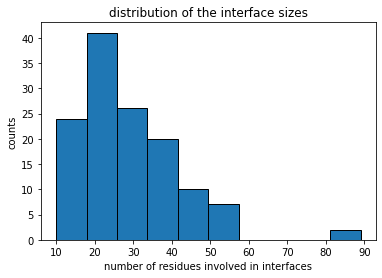

In [737]:
t53 = pd.read_csv(os.path.join(outdir, "tache5.3_taille_residus.csv"), comment='#', index_col=0)
sizes = pd.DataFrame(np.concatenate((t53.iloc[:, [0,2]], t53.iloc[:, [1,3]])),
                     columns="surface interface".split())
sizes.hist("interface", bins=10, grid=False, edgecolor='k')
plt.title("distribution of the interface sizes")
plt.xlabel("number of residues involved in interfaces")
plt.ylabel("counts")
plt.savefig(os.path.join(outdir, "tache6.2.pdf"))

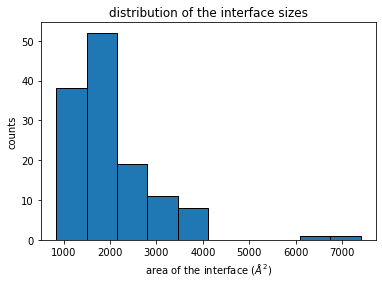

In [742]:
t54 = pd.read_csv(os.path.join(outdir, "tache5.4_taille_SASA.csv"), comment='#', index_col=0)
sizes2 = pd.DataFrame(np.concatenate((t54.iloc[:, [0,2]], t54.iloc[:, [1,3]])),
                     columns="surface interface".split())
sizes2.hist("interface", bins=10, grid=False, edgecolor='k')
plt.title("distribution of the interface sizes")
plt.xlabel("area of the interface ($\AA^2$)")
plt.ylabel("counts")
plt.savefig(os.path.join(outdir, "tache6.3.pdf"))

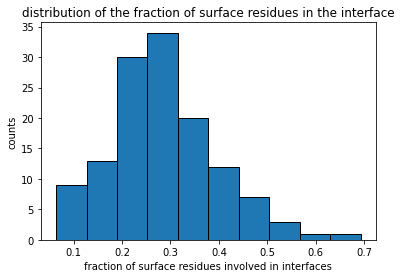

In [739]:
sizesn = sizes.loc[:, "interface"] / sizes.loc[:, "surface"]
sizesn.hist(bins=10, grid=False, edgecolor='k')
plt.title("distribution of the fraction of surface residues in the interface")
plt.xlabel("fraction of surface residues involved in interfaces")
plt.ylabel("counts")
plt.savefig(os.path.join(outdir, "tache6.4.pdf"))

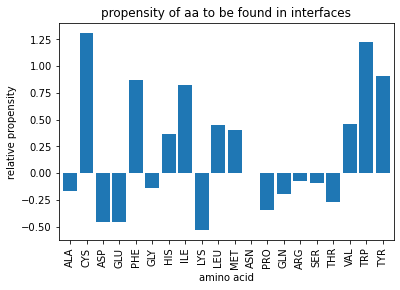

In [743]:
t55 = pd.read_csv(os.path.join(outdir, "tache5.5_frequences.csv"), comment="#", index_col=0)
t55n = t55 / t55.sum()
np.log2(t55n.iloc[:, 1] / t55n.iloc[:, 0]).plot.bar(width=0.85)
plt.xlabel("amino acid")
plt.ylabel("relative propensity")
plt.title("propensity of aa to be found in interfaces")
plt.savefig(os.path.join(outdir, "tache6.5.pdf"))

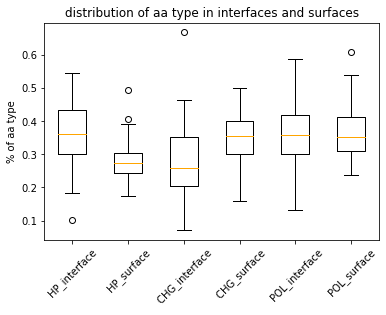

In [744]:
t56 = pd.read_csv(os.path.join(outdir, "tache5.6_frequences_types.csv"), comment="#", index_col=0)
## Assert t53 and t56 compatible
assert (t53.groupby(["surf"]*2+["inter"]*2, axis=1).sum() == t56.groupby(["surf"]*3+["inter"]*3, 
                                                                         axis=1).sum()).all().all()
surf = slice(0, 3)
inter = slice(3, 6)
t56.iloc[:, surf] = t56.iloc[:, surf].apply(lambda col: col/t56.iloc[:, surf].sum(axis=1))
t56.iloc[:, inter] = t56.iloc[:, inter].apply(lambda col: col/t56.iloc[:, inter].sum(axis=1))
t56.iloc[:, [3,0,5,2,4,1]].boxplot(rot=45, grid=False, color='k', medianprops=dict(color='orange'))
plt.ylabel("% of aa type")
plt.title("distribution of aa type in interfaces and surfaces")
plt.savefig(os.path.join(outdir, "tache6.6.pdf"))

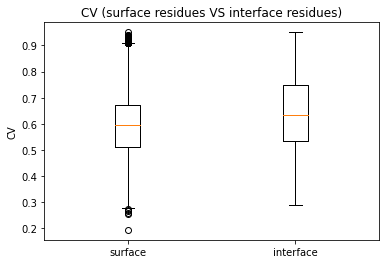

In [745]:
t5A = pd.read_csv(os.path.join(outdir, "tache5.A_CV_surface.csv"), comment="#")
t5B = pd.read_csv(os.path.join(outdir, "tache5.B_CV_interface.csv"), comment="#")
plt.title('CV (surface residues VS interface residues)')
plt.boxplot([t5A.values.flatten(), t5B.values.flatten()])
plt.xticks([1, 2], ['surface', 'interface']);
plt.ylabel("CV")
plt.savefig(os.path.join(outdir, "tache6.A.pdf"))

# Create big table
Creation du grand tableau à partir des analyses ci-dessus.

In [747]:
import pandas as pd
treated_family = "kihara"

In [753]:
full_list = pd.DataFrame.from_dict(total_sizes).transpose()
full_list.loc[:, "tot"] = full_list.apply(lambda row: row.rec + row.lig, axis=1)
inter_sizes = zip(*[(sizes[i],sizes[i+1]) for i in range(0, len(sizes), 2)])
full_list.loc[:, "inter_lig"] = next(inter_sizes)
full_list.loc[:, "inter_rec"] = next(inter_sizes)
full_list.loc[:, "type"] = full_list.apply(lambda row: row.name[0], axis=1)
full_list.index = list(map(lambda s: s[1:], full_list.index.values))
full_list = full_list.sort_values(by=["tot", "type"]).reset_index()
full_list.columns = "PDB_chains size_lig size_rec size_tot inter_lig inter_rec type".split()

In [754]:
# GET COMPND
def get_pdb_line(fname, head="COMPND"):
    retstr = ""
    with open(fname) as pdbf:
        for l in pdbf:
            if l.startswith(head):
                retstr += " " + l[10:].strip()
    return retstr
    
full_list.loc[:, "description"] = ""
for i, cp in full_list.iterrows():
    fname = "../structures/{}/raw_pdb/{}{}.pdb1".format(
        treated_family, cp.type, cp.PDB_chains[:-3])
    try:
        descr = get_pdb_line(fname)
        if descr.strip() == "":
            descr = get_pdb_line(fname, "TITLE")
        full_list.loc[i, "description"] = descr
    except Exception as e:
        print(fname)
        pass        
        

In [755]:
full_list.to_csv('../analysis/{}.csv'.format(treated_family), sep='\t')

# Aperçu
Cette section à usage interne. Lecture des tableaux de données et visualisation des complexes.

In [756]:
import pandas as pd
import nglview as nv

In [757]:
treated_family="kihara"

In [61]:
full_list = pd.read_csv('../analysis/{}.csv'.format(treated_family), sep='\t', index_col='idx')

In [758]:
dico_inter_surf = joblib.load("../analysis/dico_inter_surf_{}.job".format(treated_family))

In [759]:
def _color_by_type(s):
    return ['background-color: '+x for x in ['bisque' if s.type == "t" else 'azure' for val in s]]

with pd.option_context('display.max_rows', None):
    display(full_list.style.apply(_color_by_type, axis=1))

,PDB_chains,size_lig,size_rec,size_tot,inter_lig,inter_rec,type,description
0,2OOB_BA,44,72,116,11,14,t,"E3 ubiquitin-protein ligase CBL-B (E.C.6.3.2.-), Ubiquitin"
1,1CDT_AB,60,60,120,14,16,p,CARDIOTOXIN V4/II FROM NAJA MOSSAMBICA MOSSAMBICA: THE REFINED CRYSTAL STRUCTURE
2,1A15_AB,57,67,124,22,18,t,STROMAL DERIVED FACTOR-1ALPHA
3,1GCQ_AC,69,56,125,12,11,t,VAV AND GRB2 SH3 DOMAINS
4,1AY7_AB,89,96,185,17,19,p,"GUANYL-SPECIFIC RIBONUCLEASE SA, BARSTAR"
5,1BRS_AD,87,108,195,20,23,p,PROTEIN-PROTEIN RECOGNITION: CRYSTAL STRUCTURAL ANALYSIS OF A BARNASE- BARSTAR COMPLEX AT 2.0-A RESOLUTION
6,1FFW_AB,68,128,196,16,14,t,CHEY-BINDING DOMAIN OF CHEA IN COMPLEX WITH CHEY WITH A BOUND IMIDO DIPHOSPHATE
7,1QA9_AB,95,102,197,18,21,t,HUMAN CD2-CD58 Complex
8,1J2J_AB,41,165,206,16,18,t,ADP-ribosylation factor 1/ADP-ribosylation factor binding protein GGA1
9,1S1Q_AB,71,137,208,18,19,t,Tumor susceptibility gene 101 protein/ubiquitin


In [66]:
sorted(list(full_list.iloc[1::5,:].loc[:,"PDB_chains"].values))

['1A78_AB',
 '1AK4_AD',
 '1AKJ_AD',
 '1CDT_AB',
 '1EAW_AB',
 '1FFW_AB',
 '1I2M_AB',
 '1JTG_AB',
 '1M10_AB',
 '1WDW_AB',
 '1ZM4_AB',
 '2GOX_AB',
 '3BP8_AB',
 '3SGB_EI']

In [760]:
open("../analysis/{}.html".format(treated_family), 'w').write(full_list.style.apply(_color_by_type, axis=1).render())

101182

In [22]:
## LOOK FOR NON-CANONICAL RESIDUES
canonical = ["VAL","ILE","LEU","MET","TYR","PHE","TRP",
             "ARG","LYS","GLU","ASP",
             "SER","THR","ASN","GLN",
             "HIS",
             "ALA","CYS","GLY","PRO"]

def scream_non_canonical(pdblig):
    for chain in pdblig['chains']:
        for resi in pdblig[chain]['reslist']:
            if pdblig[chain][resi]['resname'] not in canonical:
                print("ARGH {} not canonical".format(pdblig[chain][resi]['resname']))

for i, row in full_list.iterrows():
    pdbname = row.type + row.PDB_chains
    rootname = "../structures/{}/monomers/{}".format(treated_family, pdbname)
    ligname = rootname+"_l_inter.pdb"
    recname = rootname+"_r_inter.pdb"
    scream_non_canonical(StructureTools.PDB_parser(ligname))
    scream_non_canonical(StructureTools.PDB_parser(recname))
    

In [ ]:
## LOOK FOR EXTRA ATOMS IN RESIDUES
## XXX TODO

In [23]:
def show_complex(row):
    pdbname = row.type + row.PDB_chains
    rootname = "../structures/{}/monomers/{}".format(treated_family, pdbname)
    ligname = rootname+"_l_inter.pdb"
    recname = rootname+"_r_inter.pdb"
    v = nv.NGLWidget()
    v.add_component(ligname)
    v.add_component(recname)
    v.component_0.add_representation("ball+stick", " ".join(dico_inter_surf[pdbname]["lig"]["inter"]))
    v.component_1.add_representation("ball+stick", " ".join(dico_inter_surf[pdbname]["rec"]["inter"]))
    return(v)
def show_complex_helper(i):
    v = show_complex(full_list.iloc[i, :])
    display(full_list.iloc[i, :].PDB_chains + ":" + full_list.iloc[i, :].description)
    display(v)

In [24]:
show_complex_helper(11)

'3SGB_EI: STRUCTURE OF THE COMPLEX OF STREPTOMYCES GRISEUS PROTEASE B AND THE THIRD DOMAIN OF THE TURKEY OVOMUCOID INHIBITOR AT 1.8 ANGSTROMS RESOLUTION'

NGLWidget()

# SASA max plot

In [47]:
from io import StringIO

In [12]:
sasa_max = pd.read_csv(StringIO("""Alanine	129.0	121.0	113.0	118.1
Arginine	274.0	265.0	241.0	256.0
Asparagine	195.0	187.0	158.0	165.5
Aspartate	193.0	187.0	151.0	158.7
Cysteine	167.0	148.0	140.0	146.1
Glutamate	223.0	214.0	183.0	186.2
Glutamine	225.0	214.0	189.0	193.2
Glycine	104.0	97.0	85.0	88.1
Histidine	224.0	216.0	194.0	202.5
Isoleucine	197.0	195.0	182.0	181.0
Leucine	201.0	191.0	180.0	193.1
Lysine	236.0	230.0	211.0	225.8
Methionine	224.0	203.0	204.0	203.4
Phenylalanine	240.0	228.0	218.0	222.8
Proline	159.0	154.0	143.0	146.8
Serine	155.0	143.0	122.0	129.8
Threonine	172.0	163.0	146.0	152.5
Tryptophan	285.0	264.0	259.0	266.3
Tyrosine	263.0	255.0	229.0	236.8
Valine	174.0	165.0	160.0	164.5"""), sep='\t', header=None, index_col=0,
                       names="Residue,Tian_theo,Tian_emp,Miller,Rose".split(","))


In [19]:
sasa_max.loc[:, "Residue_code"] = sasa_max.index.str[0]
sasa_max.loc["Arginine", "Residue_code"] = "R"
sasa_max.loc["Asparagine", "Residue_code"] = "N"
sasa_max.loc["Aspartate", "Residue_code"] = "D"
sasa_max.loc["Glutamate", "Residue_code"] = "E"
sasa_max.loc["Glutamine", "Residue_code"] = "Q"
sasa_max.loc["Lysine", "Residue_code"] = "K"
sasa_max.loc["Phenylalanine", "Residue_code"] = "F"
sasa_max.loc["Tyrosine", "Residue_code"] = "Y"
sasa_max.loc["Tryptophan", "Residue_code"] = "W"

In [21]:
sasa_max.sort_values(by="Residue_code", inplace=True)

Text(0, 0.5, 'SASAmax ($\\AA^2$)')

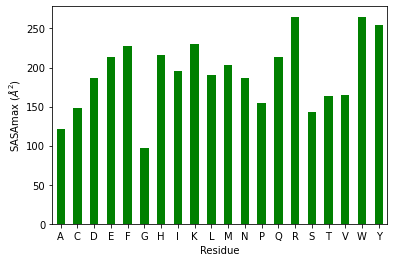

In [39]:
sasa_max.plot.bar(x="Residue_code", y="Tian_emp", rot=0, legend=None, color='g')
plt.xlabel("Residue")
plt.ylabel("SASAmax ($\AA^2$)")

# Pickle SASA results

In [113]:
import pickle
import glob
import freesasa

In [42]:
cd structures/kihara/for_site/

[Errno 2] No such file or directory: 'structures/kihara/for_site/'
/Users/marco/Dropbox/Mackup/Documents/00ENS/BIBS/BISII/repo/structures/kihara/for_site


In [43]:
def get_sasa(pdb):
    """Given a pdb file, get a SASA dict that doesn't depend on freesasa"""
    strc = freesasa.Structure(pdb)
    out = freesasa.calc(strc)
    dasa = out.residueAreas()
    for ch in dasa.keys():
        for res in dasa[ch].keys():
            tmp = dict()
            tmp["relativeTotal"] = dasa[ch][res].relativeTotal
            tmp["total"] = dasa[ch][res].total
            dasa[ch][res] = tmp
    return dasa

def do_pickle(pdb):
    """Pickle the SASA dictionary for the given pdb file"""
    pickle.dump(get_sasa(pdb), open(pdb.replace("pdb","pkl"), 'wb'))

In [32]:
for i in glob.glob("*.pdb"):
    do_pickle(i)

In [44]:
SASA = pickle.load(open("1BRS_AD_c.pkl", 'rb'))
SASAS['A']['3']['total']

FileNotFoundError: [Errno 2] No such file or directory: '1BRS_AD_c.pkl'